In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from preprocessing import get_datasets
import time
import torch.nn.functional as F


# ===== 1. 超参数配置 =====
IMG_SIZE = (256, 256)
IN_CHANNELS = 4
OUT_CHANNELS = 1
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 5
POS_WEIGHT = 15.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# ===== 2. 加载数据集 & 构建 DataLoader =====
train_dataset, test_dataset = get_datasets("USA_segmentation", image_size=IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===== 3. 定义 UNet 模型结构 =====
class UNet(nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.1)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)

        # ✅ bottleneck 改为 1024
        self.bottleneck = conv_block(512, 1024)

        # ✅ 上采样 + 拼接后通道数也要变
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)
        nn.init.constant_(self.final.bias, -2.0)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))

        return self.final(d1)



    def __init__(self, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.1)
            )
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 512)
        self.upconv4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)
        nn.init.constant_(self.final.bias, -2.0)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return self.final(d1)

# ===== 4. 初始化模型、优化器、调度器 =====
model = UNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# ===== 5. 损失函数和评估指标 =====
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum((1,2,3))
    union = pred.sum((1,2,3)) + target.sum((1,2,3))
    return 1 - ((2. * intersection + smooth) / (union + smooth)).mean()

def focal_loss(pred, target, alpha=0.75, gamma=2.5):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
    prob = torch.sigmoid(pred)
    loss = alpha * (1 - prob)**gamma * bce
    return loss.mean()

def combined_loss(pred, target):
    return focal_loss(pred, target)# + dice_loss(pred, target)

def compute_iou(pred, target, threshold=0.5):
    with torch.no_grad():
        pred_bin = (torch.sigmoid(pred) > threshold).float()
        intersection = (pred_bin * target).sum((2, 3))
        union = (pred_bin + target).clamp(0, 1).sum((2, 3))
        return (intersection / (union + 1e-8)).mean().item()


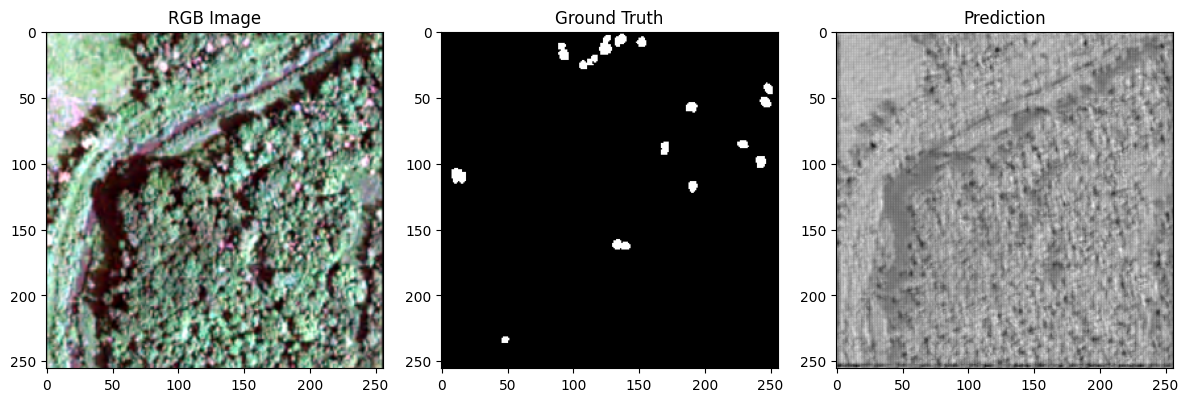

In [34]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, index=0):
    model.eval()
    img, mask = dataset[index]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(DEVICE))
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()

    img_rgb = img[:3].permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.title("RGB Image")
    plt.subplot(1, 3, 2); plt.imshow(mask_np, cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1, 3, 3); plt.imshow(pred, cmap='gray'); plt.title("Prediction")
    plt.tight_layout(); plt.show()

visualize_prediction(model, train_dataset, index=0)


In [ ]:
# ===== 6. 训练主循环 =====

best_iou = 0
patience_counter = 0

print("🚀 开始训练 U-Net")
for epoch in range(EPOCHS):
    model.train()
    total_loss, total_iou = 0, 0
    start_time = time.time()

    print(f"\n🌟 Epoch {epoch+1}/{EPOCHS} 开始")
    for batch_idx, (imgs, masks) in enumerate(train_loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = combined_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        batch_iou = compute_iou(preds, masks)
        total_loss += loss.item()
        total_iou += batch_iou

        # === 每个 batch 输出 ===
        print(f"  🌀 Batch {batch_idx+1:>3}/{len(train_loader)} | Loss: {loss.item():.4f} | IoU: {batch_iou:.4f}")
        print(f"    🔍 Pred min/max: {preds.min().item():.4f} ~ {preds.max().item():.4f}")
        print(f"    📊 Pred after sigmoid: {torch.sigmoid(preds).min().item():.4f} ~ {torch.sigmoid(preds).max().item():.4f}")

    # === 每个 epoch 输出 ===
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    current_lr = optimizer.param_groups[0]["lr"]
    elapsed = time.time() - start_time

    print(f"✅ Epoch {epoch+1}/{EPOCHS} 完成 | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | LR: {current_lr:.6f} | 耗时: {elapsed:.2f}s")

    scheduler.step(avg_iou)

    if avg_iou > best_iou:
        best_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), "best_unet_model.pth")
        print(f"🎉 最佳IoU更新为 {best_iou:.4f}，模型已保存")
    else:
        patience_counter += 1
        print(f"🕒 未提升（{patience_counter}/{PATIENCE}），等待中...")
        if patience_counter >= PATIENCE:
            print(f"🛑 Early stopping 触发。最佳 IoU = {best_iou:.4f}")
            break


🚀 开始训练 U-Net

🌟 Epoch 1/50 开始
  🌀 Batch   1/45 | Loss: 0.0686 | IoU: 0.0000
    🔍 Pred min/max: -4.8131 ~ -0.4522
    📊 Pred after sigmoid: 0.0081 ~ 0.3888
  🌀 Batch   2/45 | Loss: 0.0857 | IoU: 0.0000
    🔍 Pred min/max: -4.0655 ~ -0.1365
    📊 Pred after sigmoid: 0.0169 ~ 0.4659
  🌀 Batch   3/45 | Loss: 0.0728 | IoU: 0.0042
    🔍 Pred min/max: -3.7640 ~ 1.0769
    📊 Pred after sigmoid: 0.0227 ~ 0.7459
  🌀 Batch   4/45 | Loss: 0.0720 | IoU: 0.0335
    🔍 Pred min/max: -3.8897 ~ 1.8307
    📊 Pred after sigmoid: 0.0200 ~ 0.8619
  🌀 Batch   5/45 | Loss: 0.0791 | IoU: 0.1074
    🔍 Pred min/max: -4.0698 ~ 3.3398
    📊 Pred after sigmoid: 0.0168 ~ 0.9658
  🌀 Batch   6/45 | Loss: 0.0691 | IoU: 0.1864
    🔍 Pred min/max: -4.2985 ~ 4.3958
    📊 Pred after sigmoid: 0.0134 ~ 0.9878
  🌀 Batch   7/45 | Loss: 0.0633 | IoU: 0.1487
    🔍 Pred min/max: -4.2923 ~ 6.0966
    📊 Pred after sigmoid: 0.0135 ~ 0.9978
  🌀 Batch   8/45 | Loss: 0.0625 | IoU: 0.2276
    🔍 Pred min/max: -4.8911 ~ 8.8579
    📊 Pred

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    total_iou, total_dice = 0, 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            pred_bin = (torch.sigmoid(preds) > 0.5).float()

            intersection = (pred_bin * masks).sum((1,2,3))
            union = (pred_bin + masks).clamp(0, 1).sum((1,2,3))
            iou = (intersection / (union + 1e-8)).mean().item()
            dice = (2 * intersection / (pred_bin.sum((1,2,3)) + masks.sum((1,2,3)) + 1e-8)).mean().item()

            total_iou += iou
            total_dice += dice

    avg_iou = total_iou / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    print(f"🧪 [TEST] IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f}")
